# Pytorch notes

PyTorch тэмдэглэлүүд. Энд MNIST датаг ангилж сурах систем бичив. Жирийн python, numpy ашиглаж бичсэн систем болон ньюроны талаарх бусад тэмдэглэлийг эх нийтлэлээс хараарай. 

Link: https://wp.me/p5EUYy-fq

In [5]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
plt.style.use('seaborn-whitegrid')

# Pytorch MNIST

Here MNIST classifier is implemented with PyTorch.

### Helper functions

In [6]:
def show_img(images, n):
    '''
    Argument:
        images - loaded images
        n - number of an image to see
    -------------------------------------------------------    
    '''
    plt.imshow(images[n].numpy().squeeze(), cmap='Greys_r')
    
def show_batch(batch):
    '''
    Argument:
        batch - torch batch
    -------------------------------------------------------
    Shows batch images
    '''
    img = torchvision.utils.make_grid(batch)
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)));
    
def view_prediction(img, ps):
    '''
    Argument:
        img - test image
        ps - predicted softmax
    --------------------------------------------------------    
    Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

def predict(model, images, img_to_predict):
    '''
    Argument:
        model - neural model
        images - test images
        img_to_predict - number of image
    --------------------------------------------------------
    Predicts and shows a result
    '''
    img = images[img_to_predict].view(1, -1)
    # quering the network
    with torch.no_grad():
        logits = model.forward(img)
    # output of the network    
    ps = F.softmax(logits, dim=1)

    # seeing a predicted output
    view_prediction(img, ps)    

### Loading datasets

In [7]:
# import dataset and feaure engineering
from torchvision import datasets, transforms

In [8]:
# Batch training - batch size
batch = 64

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

# Download and load the training data
train_set = datasets.MNIST('data', download=True, train=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch, shuffle=True)

# Download and load the test data
test_set = datasets.MNIST('data', download=True, train=False, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch, shuffle=True)


0it [00:00, ?it/s]


 98%|█████████▊| 9756672/9912422 [00:03<00:00, 1833685.64it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz




0it [00:00, ?it/s]

  0%|          | 0/28881 [00:00<?, ?it/s]



32768it [00:00, 123013.75it/s]           

0it [00:00, ?it/s]

  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz




  1%|          | 16384/1648877 [00:00<00:38, 42800.99it/s]

  6%|▌         | 98304/1648877 [00:00<00:26, 58730.40it/s]

 14%|█▍        | 229376/1648877 [00:00<00:17, 82305.78it/s]

 31%|███▏      | 516096/1648877 [00:00<00:09, 116129.91it/s]

 58%|█████▊    | 958464/1648877 [00:01<00:04, 163979.73it/s]

1654784it [00:01, 1453360.54it/s]                           

0it [00:00, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz




  0%|          | 0/4542 [00:00<?, ?it/s]

8192it [00:00, 47246.25it/s]            

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


## Build model

In [9]:
from torch import nn, optim
import torch.nn.functional as F

In [10]:
n_input = 784
n_hidden = 200
n_output = 10

### Network

In [11]:
model = nn.Sequential(nn.Linear(n_input, 128),
                     nn.ReLU(),
                     nn.Linear(128, 64),
                     nn.ReLU(),
                     nn.Linear(64,10),
                     nn.LogSoftmax(dim=1))

In [12]:
# Defining gradient descent
learning_rate = 0.01
criterion = nn.NLLLoss()
optimiser = optim.SGD(model.parameters(), lr=learning_rate)


## Train and test model

In [13]:
train_iter = iter(train_loader)
images, labels = train_iter.next()

# print('Labels: ', labels)
# print('Batch shape: ', images.size())
# show_batch(images)

## Training

In [14]:
# Training the network
epochs = 5

for e in range(epochs):
    train_loss = 0
    for images, labels in train_loader:
        # Flattening an input image to vector
        images = images.view(images.shape[0], -1)
        # Initialising model parameters' gradient to zero
        optimiser.zero_grad()
        
        # Propogating forward: input -> hidden -> output
        output = model.forward(images)        
        # Calculating error at output
        loss = criterion(output, labels)
        # Propogating an error backward: output -> hidden -> input
        loss.backward()
        # Updating weight
        optimiser.step()
        
        # Recoring loss of error
        train_loss += loss.item()
        
    print(f'Training loss:{train_loss/len(train_loader)}')


9920512it [00:13, 1833685.64it/s]                             

Training loss:0.9861558909609374
Training loss:0.38300409904325694
Training loss:0.3243800445692117
Training loss:0.2927943143620293
Training loss:0.26620662324368827


### Testing

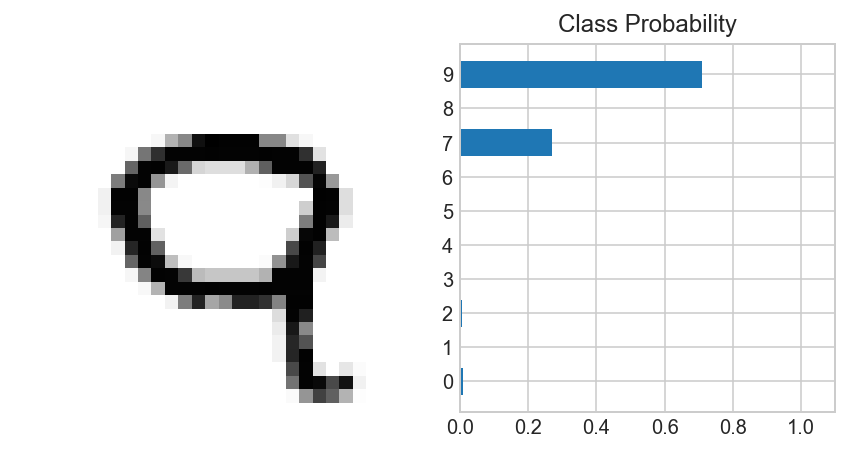

In [15]:
# Prediction
test_iter = iter(test_loader)
images, labels = test_iter.next()
img_to_predict = 19 #must be less than batch/2

img = images[img_to_predict].view(1, -1)
# quering the network
with torch.no_grad():
    logits = model.forward(img)
# output of the network    
ps = F.softmax(logits, dim=1)

# seeing a predicted output
view_prediction(img, ps)

### Save and load model

Сургасан моделоо дахиж ашиглахын тулд бас дахин дахин тест хийж системийнхээ чадварыг сайжруулахын тулд сургасан моделоо хадгалж аваад тэрийгээ дахиж дараа нь ашиглаад байж болно.

In [16]:
save_model = False
load_model = False

print("Model info: \n", model, '\n')
print("The state dict keys: \n\n", model.state_dict().keys())

Model info: 
 Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): LogSoftmax()
) 

The state dict keys: 

 odict_keys(['0.weight', '0.bias', '2.weight', '2.bias', '4.weight', '4.bias'])


In [17]:
if save_model:
    torch.save(model.state_dict(), 'model.pth')

Loading the model

In [18]:
if load_model:
    state_dict = torch.load('model.pth')
    # print(state_dict.keys())
    model.load_state_dict(state_dict)

In [19]:
# Prediction
if load_model:
    test_iter = iter(test_loader)
    images, labels = test_iter.next()
    img_to_predict = 19 #must be less than batch/2

    predict(model, images, img_to_predict)